<a href="https://colab.research.google.com/github/SalmanRafiullah/EAI6000/blob/master/Week_4_Lab_Neural_Networks_in_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4 Lab: Neural Networks in practice

In [1]:
# Global imports and settings

from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler




import keras
print("Using Keras",keras.__version__)
%matplotlib inline
plt.rcParams['figure.dpi'] = 125 # Use 300 for PDF, 100 for slides



Using TensorFlow backend.


Using Keras 2.2.5


### Overview
* Solving basic classification and regression problems
* Handling textual data
* Model selection (and overfitting)

## Solving basic problems
* Binary classification (of movie reviews)
* Multiclass classification (of news topics)
* Regression (of house prices)

Examples from _Deep Learning with Python_, by _François Chollet_

### Binary classification
* Dataset: 50,000 IMDB reviews, labeled positive (1) or negative (0)
    - Included in Keras, with a 50/50 train-test split
* Each row is one review, with only the 10,000 most frequent words retained
* Each word is replaced by a _word index_ (word ID)

In [2]:
from keras.datasets import imdb
# Download IMDB data with 10000 most frequent words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
print("Encoded review: ", train_data[0][0:10])

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original review: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]][0:10]))

Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Original review:  ? this film was just brilliant casting location scenery story


#### Preprocessing
* We can't input lists of categorical value to a neural net, we need to create tensors
* One-hot-encoding:
    -  10000 features, '1.0' if the word occurs
* Word embeddings (word2vec):
    - Map each word to a dense vector that represents it (it's _embedding_)
    - _Embedding_ layer: pre-trained layer that looks up the embedding in a dictionary 
    - Converts 2D tensor of word indices (zero-padded) to 3D tensor of embeddings
* Let's do One-Hot-Encoding for now. We'll come back to _Embedding_ layers.
* Also vectorize the labels: from 0/1 to float
    - Binary classification works with one output node

In [0]:
# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

#### Understanding the format of IMDB dataset
1. Train_data and test_data are an array of lists. What does the length of this array correspond to? What does the length of each list correspond to?
2. What are the sizes of the vectorized x_train and x_test? What do the dimensions correspond to?
3. What is the most common word in the first review in the training data? Hint: use the word index (see above)? 
4. Print the first review to verify. 

In [4]:
print(f'The length of the arrays is: {train_data.shape[0]}')
print(f'The length of the 2nd list is: {len(train_data[1])}')
print(f'The size of x_train and x_test is: {x_train.size}')
print(f'The dimensions of x_train and x_test are: {x_train.shape}')

from collections import Counter 
counts = Counter(train_data[0])
word = [name for name, age in word_index.items() if age == max(counts, key=counts.get)-3][0]
print(f'The most common word in the first review of training data is: {word}')

The length of the arrays is: 25000
The length of the 2nd list is: 189
The size of x_train and x_test is: 250000000
The dimensions of x_train and x_test are: (25000, 10000)
The most common word in the first review of training data is: the




> 1. The array length corresponds to the number of reviews. The length of each list corresponds to the number of words used for that review.
2. The size of x_train and x_test is 250,000,000. Their dimensions are 25000x10000 which corresponds to 25000 reviews and 10000 most used words with a '1.0' if the word occurs in that review.
3. The most common word in training data is 'of'.
4. The first review is printed in the next block.



In [5]:
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])

print(f'The first review of training data is:\n{decoded_review}')

The first review of training data is:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised

#### Building the network
* We can solve this problem using a network of _Dense_ layers and the _ReLU_ activation function.
* How many layers? How many hidden units for layer?
    - Start with 2 layers of 16 hidden units each
    - We'll optimize this soon
* Output layer: single unit with _sigmoid_ activation function
    - Close to 1: positive review, close to 0: negative review
* Use binary_crossentropy loss

In [6]:
from keras import models
from keras import layers 

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Model selection
* How many epochs do we need for training?
* Take a validation set of 10,000 samples from the training set
* Train the neural net and track the loss after every iteration on the validation set
    - This is returned as a `History` object by the `fit()` function 
* We start with 20 epochs in minibatches of 512 samples


In [7]:
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val))

#### Evaluate model performance during training
1. Plot the training and validation loss as a function of training epoch. Describe what happens during the training in terms of under or overfitting.
2. Plot the training and validation accuracy as a function of the training epoch.

Hint: these quantities are contained in the dict history.history.

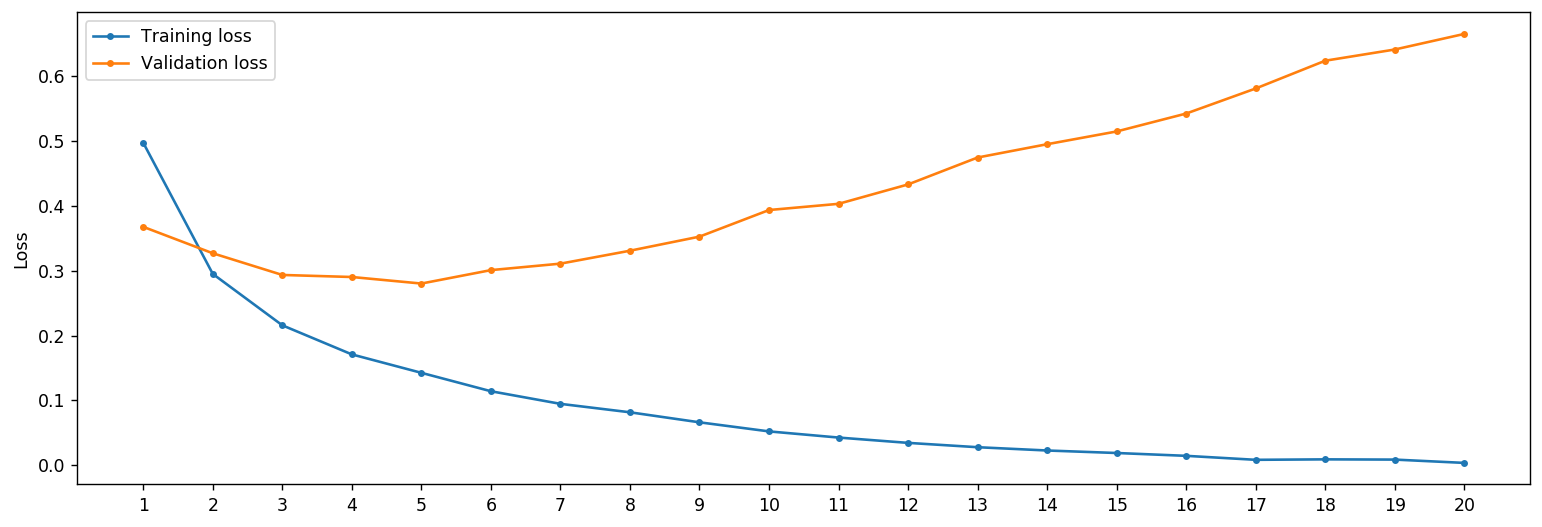

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

plt.plot(history.history['loss'], marker = '.', label = 'Training loss')
plt.plot(history.history['val_loss'], marker = '.', label = 'Validation loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(20),np.arange(21)[1:])
plt.show;

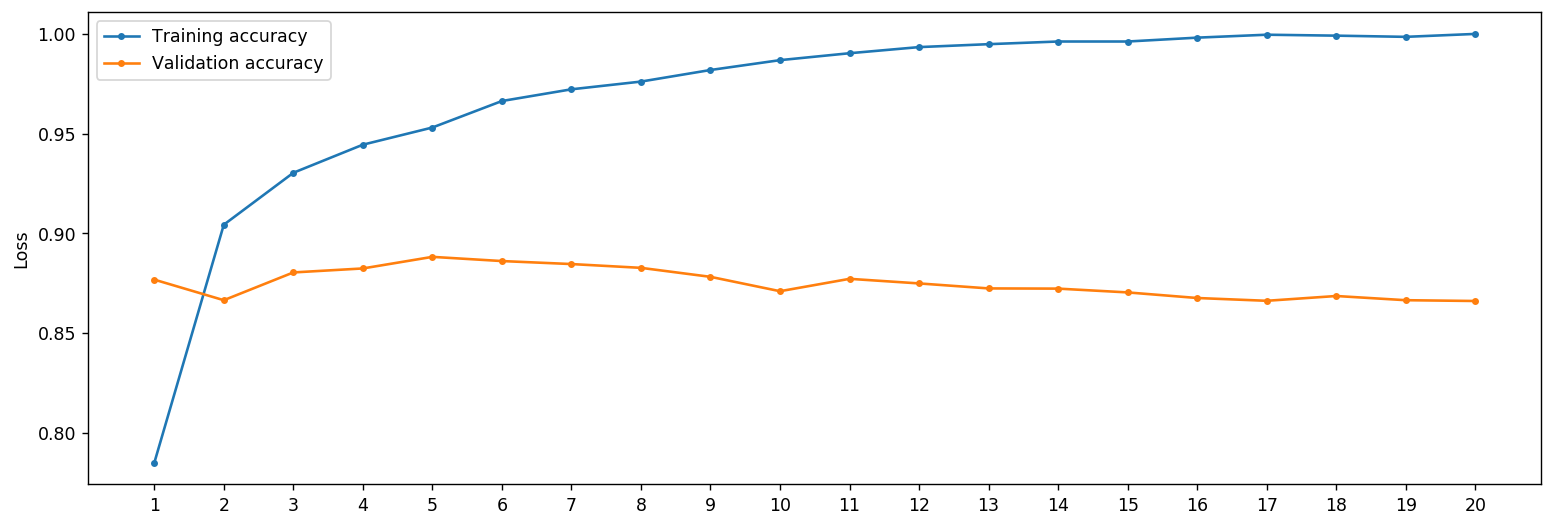

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

plt.plot(history.history['acc'], marker = '.', label = 'Training accuracy')
plt.plot(history.history['val_acc'], marker = '.', label = 'Validation accuracy')
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(20),np.arange(21)[1:])
plt.show;

#### Early stopping
One simple technique to avoid overfitting is to use the validation set to 'tune' the optimal number of epochs
* In this case, we could stop after 4 epochs


In [10]:
#@title
model.fit(x_train, y_train, epochs=4, batch_size=512, verbose=2)
result = model.evaluate(x_test, y_test)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))

Epoch 1/4
 - 2s - loss: 0.2060 - acc: 0.9462
Epoch 2/4
 - 2s - loss: 0.1319 - acc: 0.9596
Epoch 3/4
 - 2s - loss: 0.1042 - acc: 0.9677
Epoch 4/4
 - 2s - loss: 0.0801 - acc: 0.9761
25000/25000 [==============================] - 2s 71us/step
Loss: 0.4893, Accuracy:  0.8626


#### Predictions
1. Print the first review that were correctly classified along with the predicted value.
2. Print the first review that were misclassified along with the predicted value. Can you explain why the model likely failed? How confident was the model?

In [0]:
#Make predictions
probability_model = keras.Sequential([model, keras.layers.Softmax()])
#Make class predictions
class_predictions = model.predict(x_test)
#Calculate the prediction probibilities for each class for each image
prediction_probabilities = probability_model.predict(x_test)
#Predict the class of test images
y_pred = np.argmax(class_predictions,axis=-1)

In [0]:
misclassified_samples = np.where(y_pred != y_test)[0]
classified_samples = np.where(y_pred == y_test)[0]

In [13]:
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[misclassified_samples[0]]])
print(f'The first review of training data that was incorrectly classified is:\n{decoded_review}.')
print(f"It's predicted value is: {y_test[misclassified_samples[0]].astype(int)} while it's true value is {y_pred[misclassified_samples[0]]}.")

The first review of training data that was incorrectly classified is:
? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything wa

In [14]:
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[classified_samples[0]]])
print(f'The first review of training data that was correctly classified is:\n{decoded_review}.')
print(f"It's predicted value is: {y_test[classified_samples[0]].astype(int)} and it's true value is {y_pred[classified_samples[0]]}.")

The first review of training data that was correctly classified is:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are

In [15]:
print(f"The average confidence for the predictions is : {round(class_predictions.mean()*100,2)}%")

The average confidence for the predictions is : 49.6%




> The model is...... Fill this!!!




#### Takeaways
* Neural nets require a lot of preprocessing to create tensors
* Dense layers with ReLU activation can solve a wide range of problems
* Binary classification can be done with a Dense layer with a single unit, sigmoid activation, and binary cross-entropy loss
* Neural nets overfit easily
* Many design choices have an effect on accuracy and overfitting. One can try:
    - 1 or 3 hidden layers
    - more or fewer hidden units (e.g. 64)
    - MSE loss instead of binary cross-entropy
    - `tanh` activation instead of `ReLU`

### Regularization: build smaller networks
* The easiest way to avoid overfitting is to use a simpler model
* The number of learnable parameters is called the model _capacity_
* A model with more parameters has a higher _memorization capacity_
    - The entire training set can be `stored` in the weights
    - Learns the mapping from training examples to outputs
* Forcing the model to be small forces it to learn a compressed representation that generalizes better
    - Always a trade-off between too much and too little capacity
* Start with few layers and parameters, incease until you see diminisching returns

Let's try this on our movie review data, with 4 units per layer


In [0]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [0]:
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512, verbose=0,
                                   validation_data=(x_test, y_test))
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512, verbose=0,
                                       validation_data=(x_test, y_test))

1. Plot the validation loss for the original and smaller models. How does the smaller model behave compared to the original?

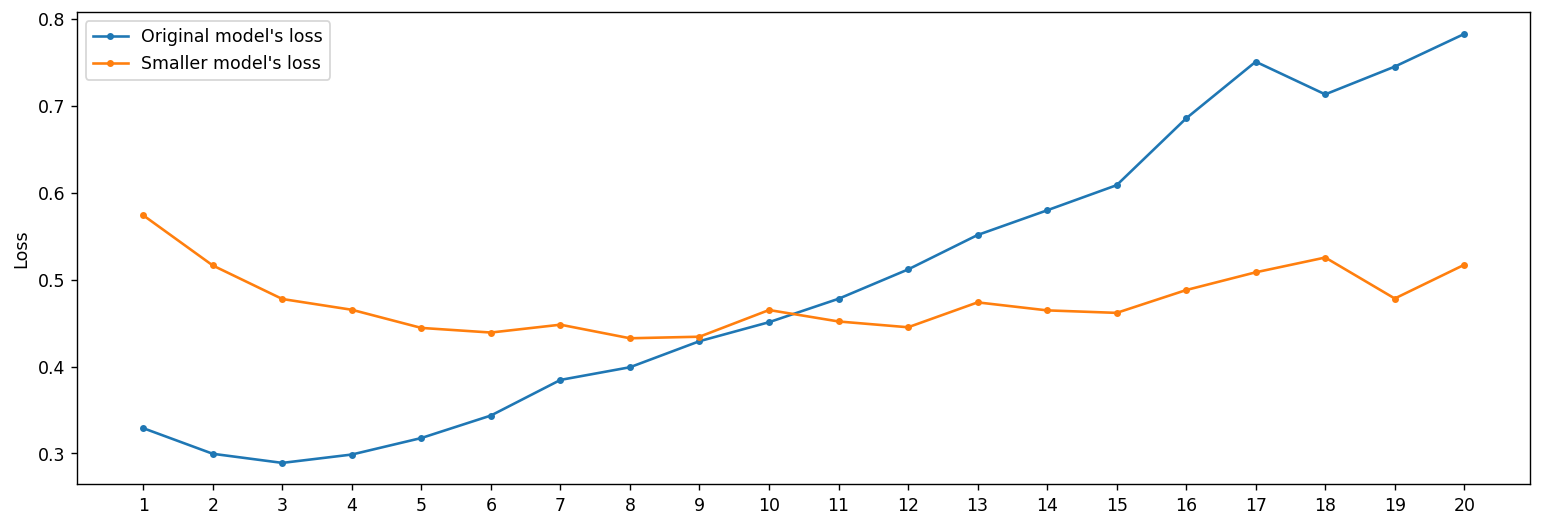

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

plt.plot(original_hist.history['val_loss'], marker = '.', label = "Original model's loss")
plt.plot(smaller_model_hist.history['val_loss'], marker = '.', label = "Smaller model's loss")
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(len(original_hist.history['loss'])),np.arange(len(original_hist.history['loss'])+1)[1:])
plt.show;



> The original model's loss is significantly higher at 20 Epochs than at lower Epochs whereas the smaller model's loss varies roughly between 0.4 and 0.6 irrespective of the number of Epochs.



### Regularization: Weight regularization
* As we did many times before, we can also add weight regularization to our loss function
- L1 regularization: leads to _sparse networks_ with many weights that are 0
- L2 regularization: leads to many very small weights
    - Also called _weight decay_ in neural net literature
* In Keras, add `kernel_regularizer` to every layer

In [0]:
from keras import regularizers
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [0]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512, verbose=0,
                             validation_data=(x_test, y_test))

1. Plot the validation loss for the original and l2 regularized models. How does the regularized model behave compared to the original?

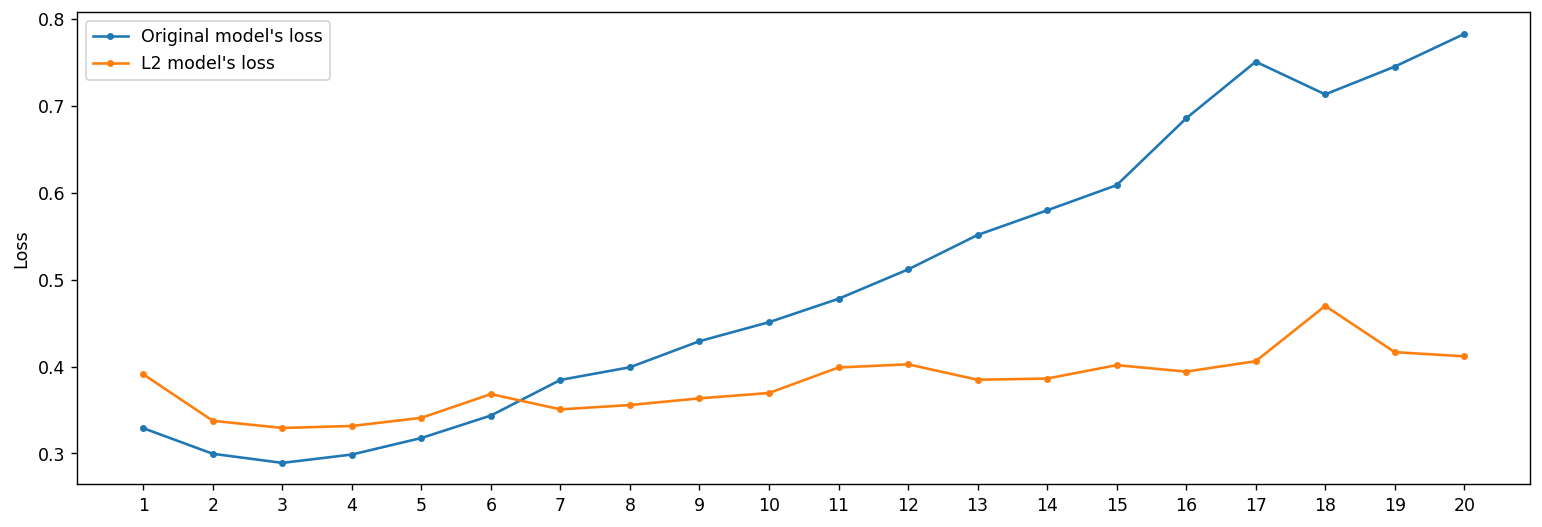

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

plt.plot(original_hist.history['val_loss'], marker = '.', label = "Original model's loss")
plt.plot(l2_model_hist.history['val_loss'], marker = '.', label = "L2 model's loss")
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(len(original_hist.history['loss'])),np.arange(len(original_hist.history['loss'])+1)[1:])
plt.show;



> The loss of the model with L2 regularization stays stable irrespective of the number of Epochs whereas the original model's loss increases almost linearly with increase in number of Epochs.



### Regularization: dropout
* One of the most effective and commonly used regularization techniques
* Randomly set a number of outputs of the layer to 0
* Idea: break up accidental non-significant learned patterns 
* _Dropout rate_: fraction of the outputs that are zeroed-out
    - Usually between 0.2 and 0.5
* At test time, nothing is dropped out, but the output values are scaled down by the dropout rate
    - Balances out that more units are active than during training
* In Keras: add `Dropout` layers between the normal layers

In [23]:
from keras import models
from keras import layers 
import matplotlib.pyplot as plt

dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               
                               batch_size=512, verbose=0,
                               validation_data=(x_test, y_test))

1. Plot the validation loss for the original and dropout models. How does the dropout model behave compared to the original?

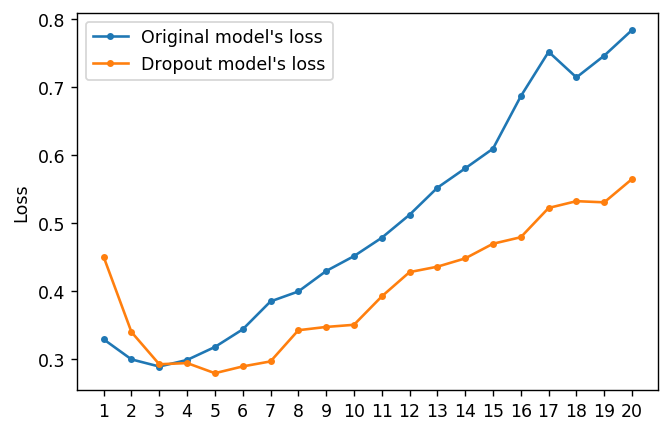

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1)

plt.plot(original_hist.history['val_loss'], marker = '.', label = "Original model's loss")
plt.plot(dpt_model_hist.history['val_loss'], marker = '.', label = "Dropout model's loss")
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(len(original_hist.history['loss'])),np.arange(len(original_hist.history['loss'])+1)[1:])
plt.show;



> The loss of the model with Dropout regularization stays is almost the same as the original model's loss. Both increasing almost linearly with increase in the number of Epochs. Reducing the dropout wight may result in a better regularized model.



### Regularization recap
* Get more training data
* Reduce the capacity of the network
* Add weight regularization
* Add dropout
* Either start with a simple model and add capacity
* Or, start with a complex model and then regularize by adding weight regularization and dropout

### Regression
* Dataset: 506 examples of houses and sale prices (Boston)
    - Included in Keras, with a 1/5 train-test split
* Each row is one house price, described by numeric properties of the house and neighborhood
* Small dataset, non-normalized features

In [0]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

#### Preprocessing
* Neural nets work a lot better if we normalize the features first. 
* Keras has no built-in support so we have to do this manually (or with scikit-learn)
    - Again, be careful not to look at the test data during normalization
    


In [0]:
mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

#### Building the network
* This is a small dataset, so easy to overfit
    * We use 2 hidden layers of 64 units each
* Use smaller batches, more epochs
* Since we want scalar output, the output layer is one unit without activation
* Loss function is Mean Squared Error (bigger penalty)
* Evaluation metric is Mean Absolute Error (more interpretable)
* We will also use cross-validation, so we wrap the model building in a function, so that we can call it multiple times

1. Create a function build_model that returns the neural network model described above

In [0]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### Cross-validation
* Keras does not have support for cross-validation
* We can implement cross-validation ourselves (seeprovided code below)
* Alternatively, we can wrap a Keras model as a scikit-learn estimator
* Generally speaking, cross-validation is tricky with neural nets
    * Some fold may not converge, or fluctuate on random initialization
    

In [29]:
# implementation of cross-validation
from keras import models
from keras import layers 
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 20
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=2)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [30]:
all_scores

[2.3368322188311286,
 2.4123695227179196,
 2.6933350374202916,
 2.5748143361346556]

1. Train for longer (200 epochs) and keep track of loss after every epoch. Plot and describe the loss as a function of epoch number.

In [31]:
from keras import backend as K
K.clear_session() # Memory clean-up


num_epochs = 200
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_loss']
    all_mae_histories.append(mae_history)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


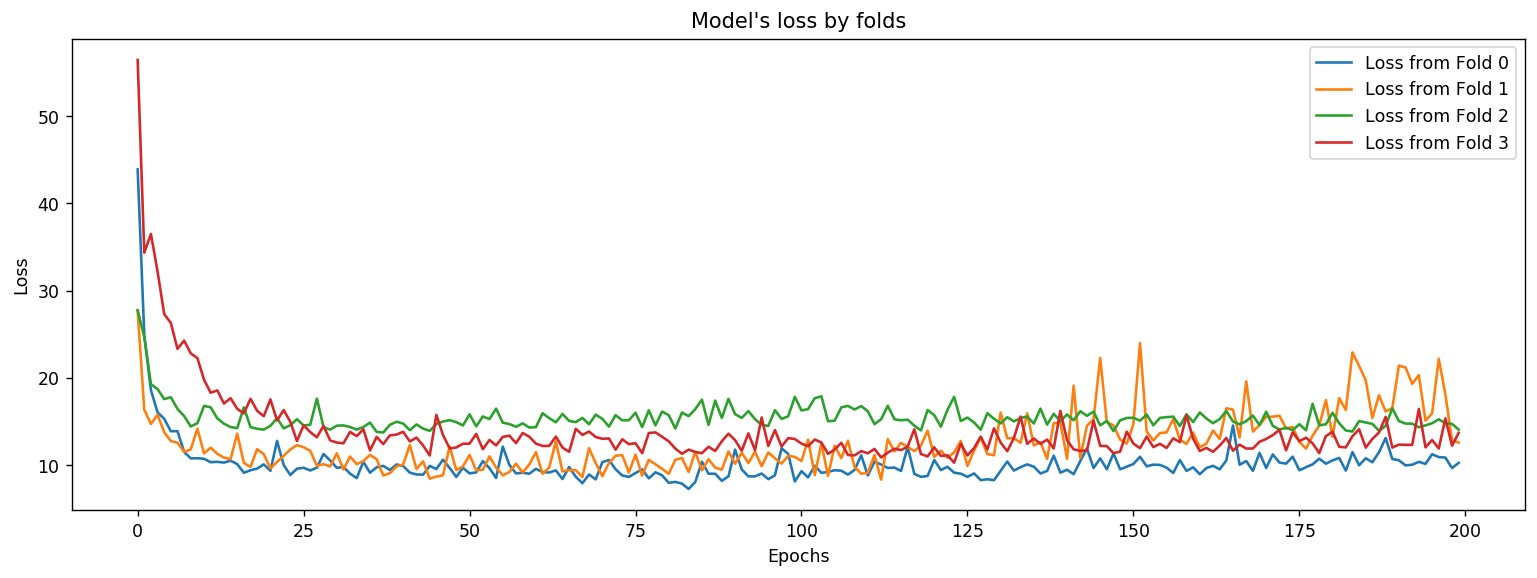

In [32]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(all_mae_histories[0],  label = "Loss from Fold 0")
ax.plot(all_mae_histories[1],  label = "Loss from Fold 1")
ax.plot(all_mae_histories[2],  label = "Loss from Fold 2")
ax.plot(all_mae_histories[3],  label = "Loss from Fold 3")
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.set_title("Model's loss by folds")
ax.legend()
plt.show();

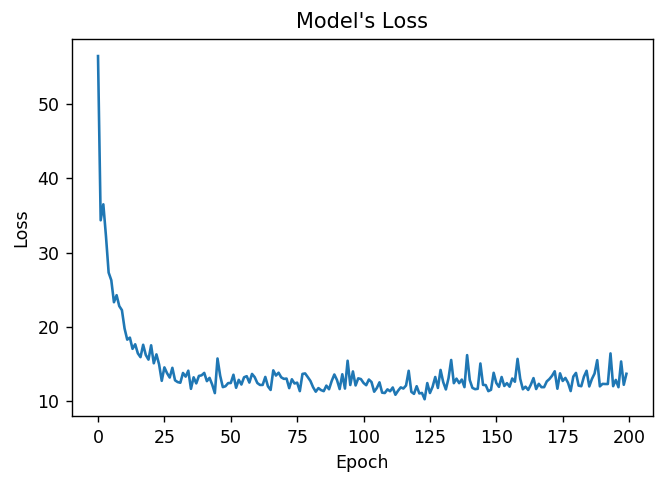

In [33]:
fig, axes = plt.subplots()
axes.plot(mae_history)
axes.set_ylabel('Loss')
axes.set_xlabel('Epoch')
axes.set_title("Model's Loss")
  #ax.xticks(np.arange(len(original_hist.history['loss'])),np.arange(len(original_hist.history['loss'])+1)[1:])
plt.show;

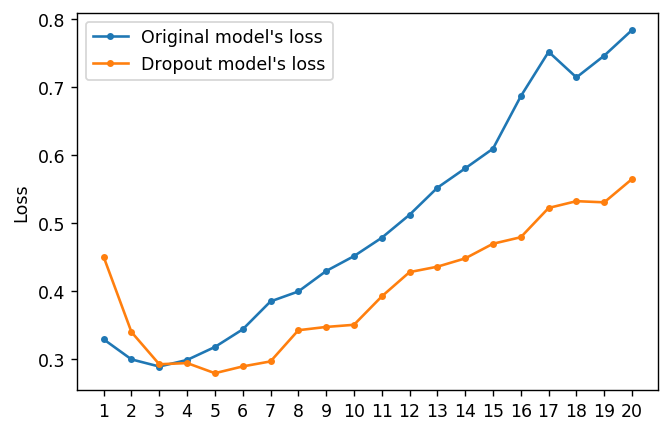

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1)

plt.plot(original_hist.history['val_loss'], marker = '.', label = "Original model's loss")
plt.plot(dpt_model_hist.history['val_loss'], marker = '.', label = "Dropout model's loss")
plt.ylabel('Loss')
plt.legend()
plt.xticks(np.arange(len(original_hist.history['loss'])),np.arange(len(original_hist.history['loss'])+1)[1:])
plt.show;

#### Takeaways
* Regression is usually done using MSE loss and MAE for evaluation
* Input data should always be scaled (independent from the test set)
* Small datasets:
    - Use cross-validation
    - Use simple (non-deep) networks
    - Smaller batches, more epochs